<a href="https://colab.research.google.com/github/rkspatel08/General_Notes/blob/main/Assignment_2_3578_rp22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PSL - Assignment 2 Submission**

Author : Rakesh Patel (rp22)

Program : MCS-DS

**Part I: Implement Lasso**

**One-variable Lasso**

Implementation of one variable lasso

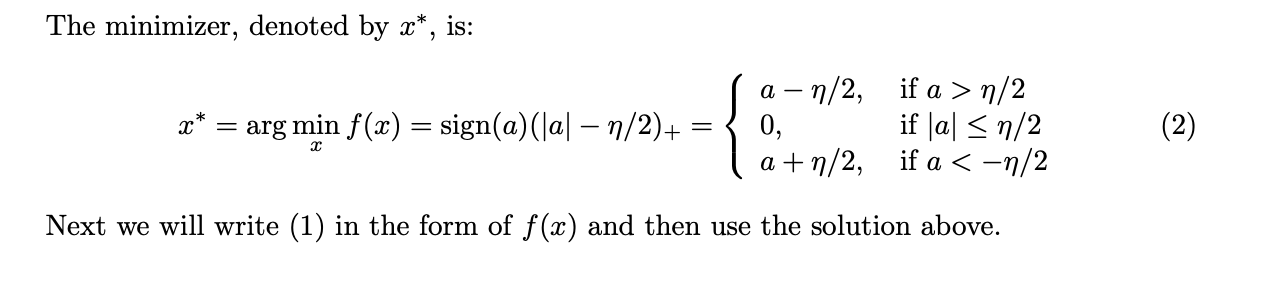

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [16]:
np.random.seed(3578);     # setting seed to last 4 of UIN

**Implementation of One Var Lasso function**

In [7]:
def one_var_lasso(v, z, lam):
  ##############################
  # YOUR CODE
  ##############################

  n = z.shape[0]

  # Calculate r^T z (dot product)
  vtz = np.dot(v.T, z)

  # Calculate ||z||^2 (squared norm)
  z_norm_squared = np.dot(z.T, z)

  # calculate v^T z / ||z||^2
  a = vtz / z_norm_squared
  eta = 2*n*lam/z_norm_squared

  if a > eta/2:
    return a - eta/2
  elif a < -eta/2:
    return a + eta/2
  else:
    return 0

**standardize X**

In [9]:
def standardize(X):
    """Standardize the input matrix X and return the standardized matrix,
    the mean, and the standard deviation of each column."""
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    standardized_X = (X - means) / stds
    return standardized_X, means, stds

**Implementation of MyLasso method**

In [10]:
def MyLasso(X, y, lam_seq, maxit=100):

    # Input
    # X: n-by-p design matrix without the intercept
    # y: n-by-1 response vector
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda

    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix
    #    with the first row being the intercept sequence

    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))  # p+1 because first row is intercept

    ##############################
    # Step 1: Standardize X
    ##############################
    newX, means, stds = standardize(X)

    # Initialize coefficients and residuals
    b = np.zeros(p)
    #r = y - np.mean(y)  # Center the response vector initially
    r = y

    # Triple nested loop: over lambda, iterations, and features
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1, 1)  # Select the j-th column of newX
                r = r + X_j * b[j]  # Restore residual before updating b_j
                b[j] = one_var_lasso(r, X_j, lam_seq[m])  # Update b_j using Lasso formula
                r = r - X_j * b[j]  # Update residual after changing b_j
        B[1:, m] = b  # Store coefficients for the current lambda

    ##############################
    # Step 2: Scale back coefficients
    ##############################
    B[1:, :] = B[1:, :] / stds.reshape(-1, 1)  # Scale back coefficients by std of X

    ##############################
    # Step 3: Compute intercepts
    ##############################
    B[0, :] = np.mean(y) - np.dot(means, B[1:, :])  # Update intercepts in B[0,]

    return B

**Load Data**

Test your function MyLasso on the data set Coding2_Data0.csv

In [11]:

url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data0.csv"
myData = pd.read_csv(url)
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

**Invoke mylasso method**

In [12]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

<ipython-input-10-a5991059896c>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b[j] = one_var_lasso(r, X_j, lam_seq[m])  # Update b_j using Lasso formula


(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

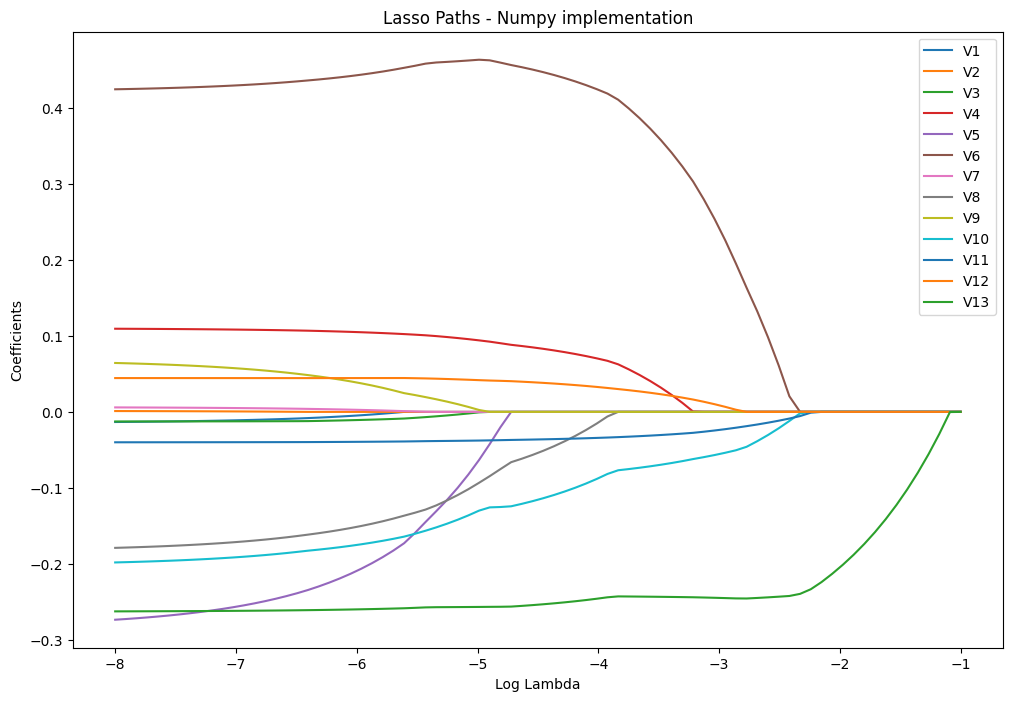

In [13]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

In [14]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_lasso_coefs.csv"
lasso_coef = pd.read_csv(url).to_numpy()
lasso_coef.shape

(14, 80)

**Compare the estimated Lasso coefficients** from your function with those provided in Coding2_lasso_coefs.csv. The maximum difference between the two coefficient matrices should be less than 0.005.

In [15]:
abs(myout - lasso_coef).max()

0.004645317415915784

**Part II: Simulation Study**

**Case 1**
Download the data set Coding2_Data1.csv. The first 14 columns are the same as the data set we used in Part I with Y being the response variable (moved to the 1st column). The additional 78 more predictors are the quadratic and pairwise product terms of the original 13 predictors.

[a] Conduct the following simulation exercise 50 times:

In each iteration, randomly split the data into two parts, 75% for training and 25% for testing.
For each of the six procedures, train a model using the training subset and generate predictions for the test subset. Record the MSPE (Mean Squared Prediction Error) based on these test data predictions.
[b] Graphically summarize your findings on the MSPE using a strip chart, and consider overlaying a boxplot for additional insights.


In [17]:
# load dataset
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data1.csv"
myData = pd.read_csv(url)
# myData.head()
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)
X.shape, len(Y)

((506, 91), 506)

**Conduct the following simulation exercise 50 times:**


a. In each iteration, randomly split the data into two parts, 75% for training and 25% for testing.

b. For each of the six procedures, train a model using the training subset and generate predictions for the test subset. Record the MSPE (Mean Squared Prediction Error) based on these test data predictions.

In [18]:
# randomly split the data into two parts, 75% for training and 25% for testing.
def split_train_test(X, Y):
  # Splitting the data into training and testing sets
  n = len(Y)
  indices = np.arange(0, n)
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*n))]
  train_ind = indices[len(test_ind):]

  # Splitting the data into training and testing sets
  X_train1 = X.iloc[train_ind]
  Y_train = Y[train_ind]
  X_test1 = X.iloc[test_ind]
  Y_test = Y[test_ind]
  scaler = StandardScaler(with_mean=True, with_std=True)
  X_train = scaler.fit_transform(X_train1)
  X_test = scaler.transform(X_test1)
  return X_train, Y_train, X_test, Y_test

PCR Implemenation (as given in sample code)

In [19]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Run simulations,split the train and test data and train below models:

**Full**: Fit a linear regression model using all features

**Ridge.min** : Ridge regression using lambda.min

**Lasso.min and Lasso.1se:** Lasso using lambda.min or lambda.1se

**L.Refit:** Refit the model selected by Lasso using lambda.1se

**PCR**: principle components regression with the number of components chosen by 10-fold cross validation

In [21]:
# run simulation 50 times and train given models
sims = 50
full_mse_list, ridge_mse_list, lasso_min_list,lasso_1se_list ,refit_mse_list, pcr_mse_list = [], [], [],[], [], []

for i in range(sims):
  X_train, Y_train, X_test, Y_test = split_train_test(X, Y)

  #Full: Fit a linear regression model using all features
  full_molel = lm().fit(X_train, Y_train)
  full_mse = mean_squared_error(Y_test, full_molel.predict(X_test))
  full_mse_list.append(full_mse)

  #Ridge.min : Ridge regression using lambda.min
  ridge_alphas = np.logspace(-10, 1, 100)
  ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                  scoring = 'neg_mean_squared_error')
  ridgecv.fit(X_train, Y_train)
  ridge_model = Ridge(alpha = ridgecv.alpha_)
  ridge_model.fit(X_train, Y_train)
  ridge_model_mse = mean_squared_error(Y_test, ridge_model.predict(X_test))
  ridge_mse_list.append(ridge_model_mse)

  lasso_alphas = np.logspace(-10, 1, 100)
  lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
  lassocv.fit(X_train, Y_train)
  mean_mse = np.mean(lassocv.mse_path_, axis=1)
  std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)
  cv_alphas = lassocv.alphas_
  min_idx = np.argmin(mean_mse)
  alpha_min = cv_alphas[min_idx]
  threshold = mean_mse[min_idx] + std_mse[min_idx]
  alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

  #lasso using lambda min
  lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
  lasso_model_min.fit(X_train, Y_train)
  lasso_min_mse = mean_squared_error(Y_test, lasso_model_min.predict(X_test))
  lasso_min_list.append(lasso_min_mse)

  #lasso using lambda_1se
  lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
  lasso_model_1se.fit(X_train, Y_train)
  lasso_1se_mse = mean_squared_error(Y_test, lasso_model_1se.predict(X_test))
  lasso_1se_list.append(lasso_1se_mse)

  #Refit the model selected by Lasso using lambda.1se
  nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
  lm_refit = lm()
  lm_refit.fit(X_train[:, nonzero_indices], Y_train)
  lasso_1se_refit_mse = mean_squared_error(Y_test, lm_refit.predict(X_test[:, nonzero_indices]))
  refit_mse_list.append(lasso_1se_refit_mse)

  # pcr training and mse capturing
  pcr = PCR()
  pcr.fit(X_train,  Y_train.to_numpy())
  pcr_mse = mean_squared_error(Y_test, pcr.predict(X_test))
  pcr_mse_list.append(pcr_mse)



**Graphical Summary of simulations for case 1:**

Graphically summarize your findings on the MSPE using a strip chart, and consider overlaying a boxplot for additional insights.

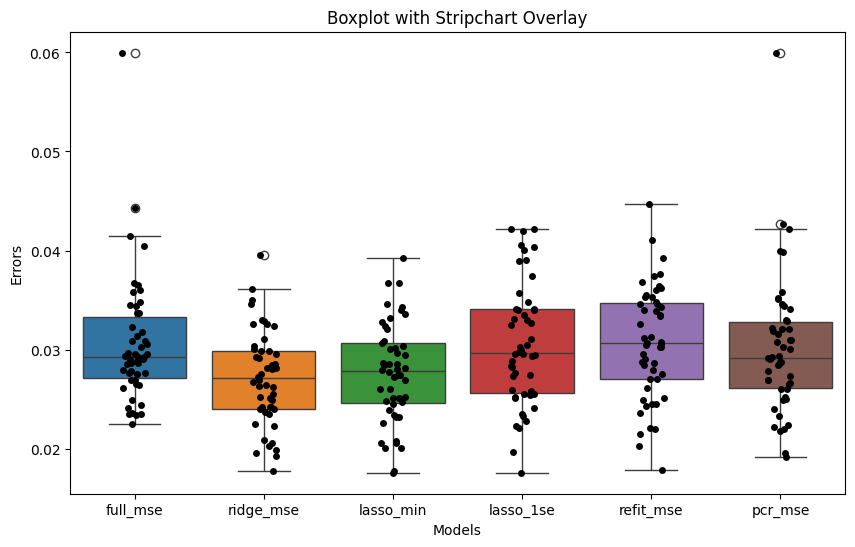

In [22]:
full_mse_list,ridge_mse_list, lasso_min_list,lasso_1se_list, refit_mse_list, pcr_mse_list
# Combine lists into a dataframe for easier plotting
data = pd.DataFrame({
    'full_mse': full_mse_list,
    'ridge_mse': ridge_mse_list,
    'lasso_min': lasso_min_list,
    'lasso_1se': lasso_1se_list,
    'refit_mse': refit_mse_list,
    'pcr_mse':pcr_mse_list
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)

# Overlay the stripchart
sns.stripplot(data=data, jitter=True, color='black')

plt.xlabel('Models')
plt.ylabel('Errors')
plt.title('Boxplot with Stripchart Overlay')
plt.show()

**Observations**:

Based on the outcomes of your simulation study, please address the following questions:

1. Which procedure or procedures yield the best performance in terms of MSPE

  A1 : Ridge Regression using lambda.min yields lowest MSPE for simulations. Lasso using lambda.min also have comparable results.
2. Conversely, which procedure or procedures show the poorest performance?

  A2 - Lasso using lambda.1se has poorest performance for given simulation study.
3. In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?

  A3 - Lasso.min yields better MSPE i.e. lower error.
4. Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?

  A4 - Refitting looks like not much advantageous here as the average errors for both Lasso.1se and Lasso refitted using 1se looks similar.
5. Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?

  A5 - Varialbe selection is certainly helpful here as Performance of full model slighlty improved when variables were scaled down or set to zero in Ridge regression and Lasso minimum. Performance of both Ridge and Lasso minimum models are better than full model.


**Simulation Study : Case 2**


Download the data set Coding2_Data2.csv. The first 92 columns are identical to those in Coding2_Data1.csv, with the addition of 500 columns of artificially generated noise features.

In [23]:
url = "https://raw.githubusercontent.com/liangfgithub/liangfgithub.github.io/master/Data/Coding2_Data2.csv"
myData = pd.read_csv(url)
# myData.head()
Y_case2 = myData['Y']
X_case2 = myData.drop(['Y'], axis = 1)
X.shape, len(Y)

((506, 91), 506)

**Run simulation for case 2:**

Repeat [a] and [b] above for the five procedures excluding the Full procedure.

In [ ]:
# run simulation 50 times and train given models
sims = 50
ridge_mse_list2, lasso_min_list2,lasso_1se_list2 ,refit_mse_list2, pcr_mse_list2 =  [], [],[], [], []

for i in range(sims):
  X_train, Y_train, X_test, Y_test = split_train_test(X_case2, Y_case2)

  #Full: Fit a linear regression model using all features
  #full_molel = lm().fit(X_train, Y_train)
  #full_mse = mean_squared_error(Y_test, full_molel.predict(X_test))
  #full_mse_list.append(full_mse)

  #Ridge.min : Ridge regression using lambda.min
  ridge_alphas = np.logspace(-10, 1, 100)
  ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                  scoring = 'neg_mean_squared_error')
  ridgecv.fit(X_train, Y_train)
  ridge_model = Ridge(alpha = ridgecv.alpha_)
  ridge_model.fit(X_train, Y_train)
  ridge_model_mse = mean_squared_error(Y_test, ridge_model.predict(X_test))
  ridge_mse_list2.append(ridge_model_mse)

  lasso_alphas = np.logspace(-10, 1, 100)
  lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
  lassocv.fit(X_train, Y_train)
  mean_mse = np.mean(lassocv.mse_path_, axis=1)
  std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)
  cv_alphas = lassocv.alphas_
  min_idx = np.argmin(mean_mse)
  alpha_min = cv_alphas[min_idx]
  threshold = mean_mse[min_idx] + std_mse[min_idx]
  alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

  #lasso using lambda min
  lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
  lasso_model_min.fit(X_train, Y_train)
  lasso_min_mse = mean_squared_error(Y_test, lasso_model_min.predict(X_test))
  lasso_min_list2.append(lasso_min_mse)

  #lasso using lambda_1se
  lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
  lasso_model_1se.fit(X_train, Y_train)
  lasso_1se_mse = mean_squared_error(Y_test, lasso_model_1se.predict(X_test))
  lasso_1se_list2.append(lasso_1se_mse)

  #Refit the model selected by Lasso using lambda.1se
  nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
  lm_refit = lm()
  lm_refit.fit(X_train[:, nonzero_indices], Y_train)
  lasso_1se_refit_mse = mean_squared_error(Y_test, lm_refit.predict(X_test[:, nonzero_indices]))
  refit_mse_list2.append(lasso_1se_refit_mse)

  # pcr training and mse capturing
  pcr = PCR()
  pcr.fit(X_train,  Y_train.to_numpy())
  pcr_mse = mean_squared_error(Y_test, pcr.predict(X_test))
  pcr_mse_list2.append(pcr_mse)



**Graphical Summary of simulations for case 2:**

Graphically summarize your findings on the MSPE using a strip chart, and consider overlaying a boxplot for additional insights.

In [ ]:
#full_mse_list,ridge_mse_list, lasso_min_list,lasso_1se_list, refit_mse_list, pcr_mse_list
# Combine lists into a dataframe for easier plotting
data_case2 = pd.DataFrame({
    'ridge_mse': ridge_mse_list2,
    'lasso_min': lasso_min_list2,
    'lasso_1se': lasso_1se_list2,
    'refit_mse': refit_mse_list2,
    'pcr_mse':pcr_mse_list2
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_case2)

# Overlay the stripchart
sns.stripplot(data=data_case2, jitter=True, color='black')

plt.xlabel('Models')
plt.ylabel('Errors')
plt.title('Boxplot with Stripchart Overlay')
plt.show()

**Observations Case 2**:

Based on the outcomes of your simulation study, please address the following questions:

1. Which procedure or procedures yield the best performance in terms of MSPE

  A1 : Ridge Regression using lambda.min yields lowest MSPE for simulations. Lasso using lambda.min also have comparable results.
2. Conversely, which procedure or procedures show the poorest performance?

  A2 - Lasso using lambda.1se has poorest performance for given simulation study.
3. In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?

  A3 - Lasso.min yields better MSPE i.e. lower error.
4. Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?

  A4 - Refitting looks like not much advantageous here as the average errors for both Lasso.1se and Lasso refitted using 1se looks similar.
5. Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?

  A5 - Varialbe selection is certainly helpful here as Performance of full model slighlty improved when variables were scaled down or set to zero in Ridge regression and Lasso minimum. Performance of both Ridge and Lasso minimum models are better than full model.
